In [ ]:
! pip install pillow

In [137]:
import os
import numpy as np
import random
from PIL import Image
IMAGE_PATH = "assets/visual_crypto"

BLACK = 0
WHITE = 255
BLACK_RGB = (0, 0, 0)
WHITE_RGB = (255, 255, 255)
TRANSPERANT_WHITE_RGB = (255, 255, 255, 0)

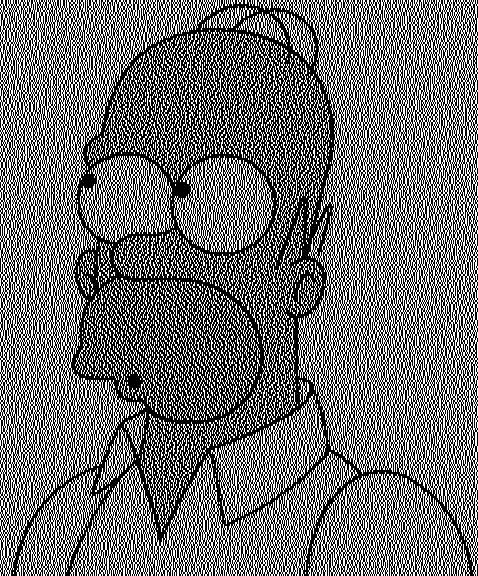

In [138]:
def superimpose_images(image_1, image_2):
    merged_image = image_2.copy()
    image_1 = image_1.convert("RGBA")
    data = image_1.getdata()
    new_data = []
    for item in data:
        if item[:3] == WHITE_RGB:
            new_data.append(TRANSPERANT_WHITE_RGB)
        else:
            new_data.append(item)
    image_1.putdata(new_data)
    merged_image.paste(image_1, (0, 0), image_1)
    return merged_image

def tiles_to_image(tiles, height, width):
    tiles = np.array(tiles).reshape(height, width, 2, 2)
    tiles = np.concatenate(tiles, axis=1)
    tiles = np.concatenate(tiles, axis=1)
    return Image.fromarray(tiles.astype(np.uint8))

def simple_image_split(image):
    """Splits the image into two random shares."""
    black_left_half = np.array([[BLACK, WHITE],[BLACK, WHITE]])
    black_right_half = np.array([[WHITE, BLACK],[WHITE, BLACK]])
    pixel_values = {BLACK: 1, WHITE: 0}
    tiles = {0: black_left_half, 1: black_right_half}

    width = image.size[0] // 2
    height = image.size[1] // 2
    pixels = image.resize((width, height)).convert('1').getdata()

    share_1 = [random.choice([0, 1]) for _ in range(len(pixels))]
    share_2 = [share_1[i] ^ pixel_values[pixels[i]] for i in range(len(pixels))]

    share_1_tiles = [tiles[pixel] for pixel in share_1]
    share_2_tiles = [tiles[pixel] for pixel in share_2]

    new_image_1 = tiles_to_image(share_1_tiles, height, width)
    new_image_2 = tiles_to_image(share_2_tiles, height, width)

    return (new_image_1, new_image_2)

image = Image.open(os.path.join(IMAGE_PATH, "homer.png"))
new_image_1, new_image_2 = simple_image_split(image)
display(superimpose_images(new_image_1, new_image_2))

# Multiple image share

We'll use the idea from the Naor & Shamir paper

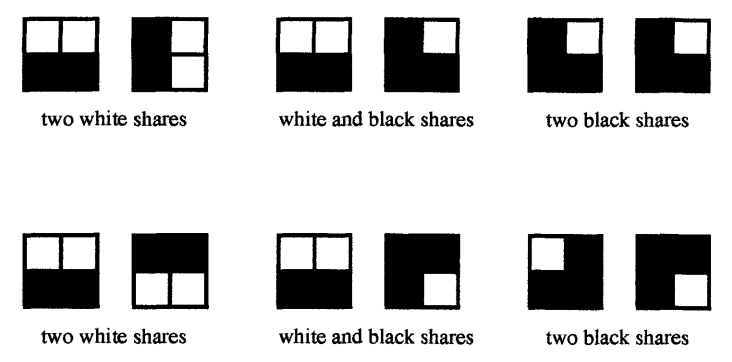

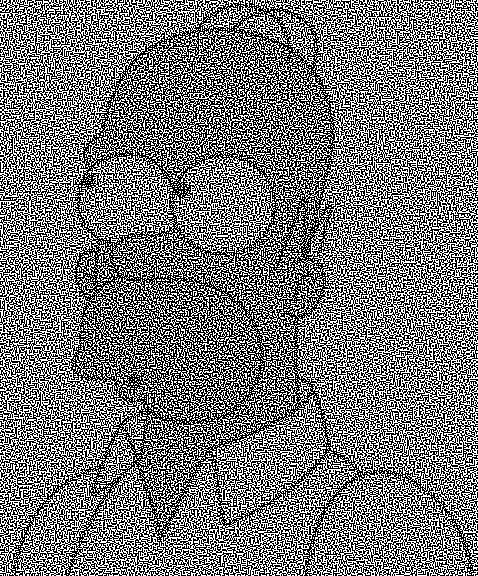

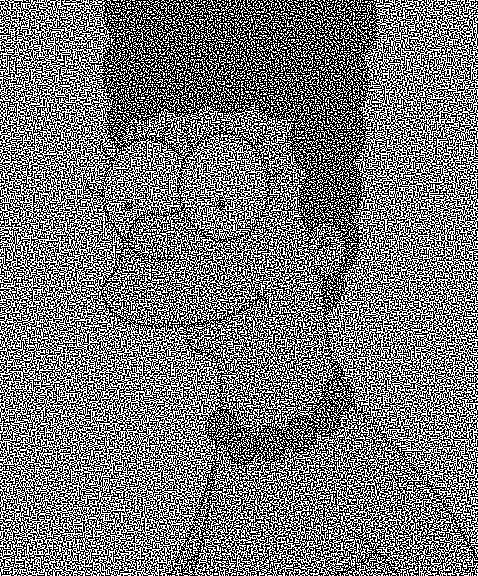

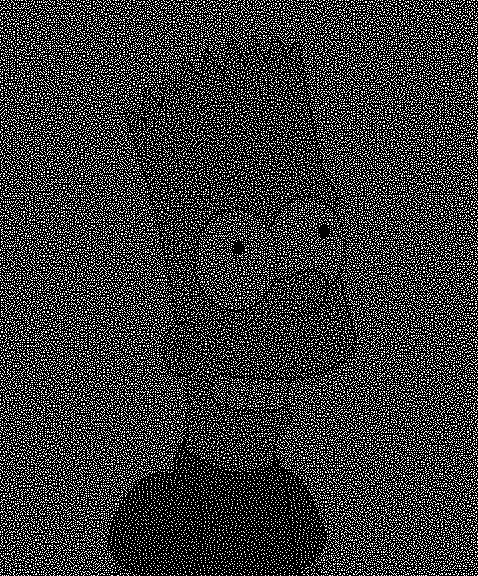

In [139]:
half_white_tile = np.array([[WHITE, WHITE],[BLACK, BLACK]])
almost_black_tile = np.array([[BLACK, WHITE],[BLACK, BLACK]])


translation_table={
        # (first source color, second source color, target color): (share1 tile, share2 tile)
        (BLACK, BLACK, BLACK): (almost_black_tile, np.rot90(almost_black_tile, 2)),
        (BLACK, BLACK, WHITE): (almost_black_tile, almost_black_tile),
        (BLACK, WHITE, BLACK): (almost_black_tile, np.rot90(half_white_tile)),
        (BLACK, WHITE, WHITE): (almost_black_tile, half_white_tile),
        (WHITE, BLACK, BLACK): (np.rot90(half_white_tile), almost_black_tile),
        (WHITE, BLACK, WHITE): (half_white_tile, almost_black_tile),
        (WHITE, WHITE, BLACK): (half_white_tile, np.rot90(half_white_tile, 2)),
        (WHITE, WHITE, WHITE): (half_white_tile, np.rot90(half_white_tile)),
}

def multiple_image_share(source_1, source_2, target):
        if target.size[0] != source_1.size[0] or target.size[1] != source_1.size[1] or target.size[0] != source_2.size[0] or target.size[1] != source_2.size[1]:
            raise ValueError("Source and target images must have the same dimensions.")
        width = target.size[0] // 2
        height = target.size[1] // 2
        pixels = zip(*[list(image.resize((width, height)).convert('1').getdata()) for image in [source_1, source_2, target]])

        share_1_tiles = []
        share_2_tiles = []
        for pixel in pixels:
            rotation = random.choice([0, 1, 2, 3])
            share_1_tile, share_2_tile = translation_table[(pixel[0], pixel[1], pixel[2])]
            share_1_tiles.append(np.rot90(share_1_tile, rotation))
            share_2_tiles.append(np.rot90(share_2_tile, rotation))
       

        new_image_1 = tiles_to_image(share_1_tiles, height, width)
        new_image_2 = tiles_to_image(share_2_tiles, height, width)

        return new_image_1, new_image_2

source_1 = Image.open(os.path.join(IMAGE_PATH, "homer.png"))
source_2 = Image.open(os.path.join(IMAGE_PATH, "marge.png"))
target = Image.open(os.path.join(IMAGE_PATH, "bart.png"))

source_2 = source_2.resize((source_1.size[0], source_1.size[1]))
target = target.resize((source_1.size[0], source_1.size[1]))
new_image_1, new_image_2 = multiple_image_share(source_1, source_2, target)
display(new_image_1)
display(new_image_2)
display(superimpose_images(new_image_1, new_image_2))